### Sampling a dataset in spherical coordinates along an arbitrary cartesian plane with derived fields and cut regions

In addition to yt, this notebook uses ipympl for interactive 3d plotting

In [1]:
import yt
import numpy as np 
from yt.testing import fake_amr_ds

In [2]:
ds = fake_amr_ds(geometry='spherical')

yt : [INFO     ] 2023-11-27 12:03:56,564 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-11-27 12:03:56,565 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2023-11-27 12:03:56,565 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-27 12:03:56,566 Parameters: domain_right_edge         = [1.         3.14159265 6.28318531]
yt : [INFO     ] 2023-11-27 12:03:56,567 Parameters: cosmological_simulation   = 0


### geometry setup

add some functions and derived fields for calculating cartesian coordinates from spherical. In yt, `phi` is the longitudinal angle (from 0 to 2pi), `theta` is 0 at the north pole, pi at the south. 

In [3]:
def to_cartesian(r, theta, phi):
    z = r * np.cos(theta)
    xy = r * np.sin(theta)
    x = xy * np.cos(phi)
    y = xy * np.sin(phi)
    return x, y, z


In [4]:
def _x(field, data):
    return data[('index', 'r')] * np.sin(data[('index', 'theta')]) * np.cos(data[('index', 'phi')])
    
def _y(field, data):
    return data[('index', 'r')] * np.sin(data[('index', 'theta')]) * np.sin(data[('index', 'phi')])

def _z(field, data):
    return data[('index', 'r')] * np.cos(data[('index', 'theta')])

ds.add_field(
    name=("index", "x"),
    function=_x,
    sampling_type="local",
    units="code_length",    
)

ds.add_field(
    name=("index", "y"),
    function=_y,
    sampling_type="local",
    units="code_length",    
)

ds.add_field(
    name=("index", "z"),
    function=_z,
    sampling_type="local",
    units="code_length",    
)

Now create a derived field that takes any 3 points in spherical coordinates and:

* constructs a cartesian plane from those 3 points
* calculates the distance to that plane

Note that we're defining the points initially **outside** the scope of the function so that we can later change these values without overriding the field

In [5]:
pt1 = (1.0, 20. * np.pi/180, 45. * np.pi/180)
pt2 = (1.0, 35. * np.pi/180, 75. * np.pi/180)
pt3 = (0., 0., 0.)

def _dist_from_plane(field, data):
    # always recalculate the cartesian plane in case
    # points have changed
    pt1_xyz = np.array(to_cartesian(*pt1))
    pt2_xyz = np.array(to_cartesian(*pt2))
    pt3_xyz = np.array(to_cartesian(*pt3))
    vec1 = pt1_xyz - pt3_xyz
    vec2 = pt2_xyz - pt3_xyz
    normal_vec = np.cross(vec1, vec2)
    vec_mag = np.sqrt(np.sum(normal_vec ** 2))
    normal_vec = normal_vec / vec_mag
    
    # get cartesian points of each data point
    x = data['index', 'x'].d
    y = data['index', 'y'].d
    z = data['index', 'z'].d
        
    # vector from each point to point on plane
    dist_vec = (x - pt1_xyz[0], y - pt1_xyz[1], z - pt1_xyz[2])
    
    # distance to plane for each point 
    dist = np.zeros(x.shape)
    for idim in range(3):
        dist += dist_vec[idim] * normal_vec[idim]
    dist = np.abs(dist) 
    return data.ds.arr(dist, 'code_length')

In [6]:
ds.add_field(
    name=("index", "dist_from_plane"),
    function=_dist_from_plane,
    sampling_type="local",
    units="code_length",
    force_override=True,
)

now, to select points within a given distance from the plane, we can use a cut region:

In [7]:
cr = ds.cut_region(ds.all_data(), ["obj[('index', 'dist_from_plane')] < 0.01"])

and then extract any of the values

In [8]:
d = cr[('stream', 'Density')]
x = cr[('index', 'x')]
y = cr[('index', 'y')]
z = cr[('index', 'z')]
r = cr[('index', 'r')]
print(r.shape)

(3803,)


what we get out are 1D arrays with a length that matches the number of points within our selected distance. 

Making a plot out of these points will require some additional steps. 

First, let's load up these points in 3D just to check they make sense:

In [9]:
%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

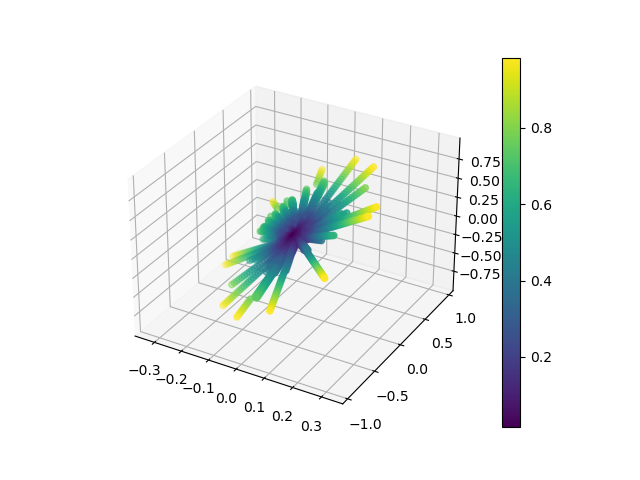

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=r)
plt.colorbar(sc, ax=ax)
plt.show()

So it looks like we're getting out our points as expected -- the gaps in data relate to the resolution of the initial data:

yt : [INFO     ] 2023-11-27 12:05:18,527 xlim = 0.000000 1.000000
yt : [INFO     ] 2023-11-27 12:05:18,527 ylim = -1.000000 1.000000
yt : [INFO     ] 2023-11-27 12:05:18,527 Setting origin='native' for spherical geometry.
yt : [INFO     ] 2023-11-27 12:05:18,530 xlim = 0.000000 1.000000
yt : [INFO     ] 2023-11-27 12:05:18,531 ylim = -1.000000 1.000000
yt : [INFO     ] 2023-11-27 12:05:18,532 Making a fixed resolution buffer of (('stream', 'Density')) 800 by 800



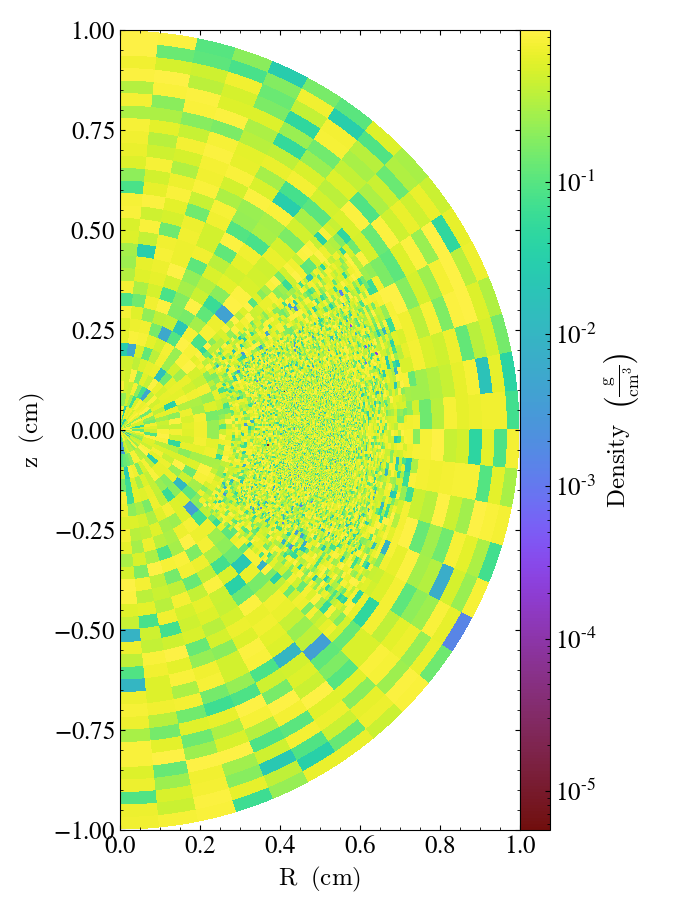

In [16]:
slc = yt.SlicePlot(ds, 'phi', ('stream', 'Density'))
slc.show()

because the outer points have a lower resolution and our cut region selects a single point for each of those cells, our 3d plot appears to have some gaps (because we're plotting single points).

Let's try adjusting our 3rd point to use another point on the surface

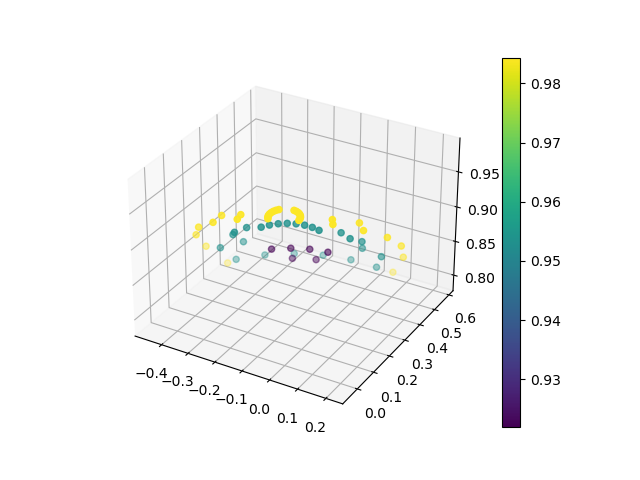

In [17]:
pt3 = (1.0, 35. * np.pi/180, 150. * np.pi/180)
cr = ds.cut_region(ds.all_data(), ["obj[('index', 'dist_from_plane')] < 0.01"])

x = cr[('index', 'x')]
y = cr[('index', 'y')]
z = cr[('index', 'z')]
r = cr[('index', 'r')]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=r)

plt.colorbar(sc, ax=ax)
plt.show()

and increasing the distance from the plane, we'll pick up more points

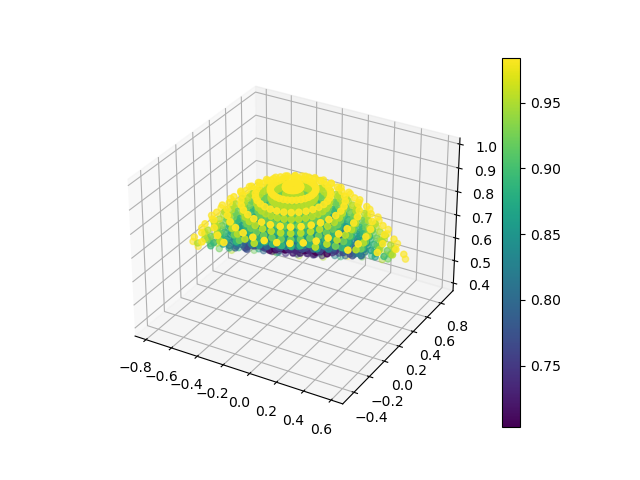

In [24]:
cr = ds.cut_region(ds.all_data(), ["obj[('index', 'dist_from_plane')] < 0.25"])

x = cr[('index', 'x')]
y = cr[('index', 'y')]
z = cr[('index', 'z')]
r = cr[('index', 'r')]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=r)

plt.colorbar(sc, ax=ax)
plt.show()

So to create a 2D image along the plane, we need to fill in 